In [1]:
import torch
import numpy as np
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
from pde import GenerateData, NeuralNet, LinearQuadraticRegulator2D
from tqdm import tqdm

In [2]:
generateData = GenerateData(domain=([0, 1], [0, 1]))

In [3]:
points = generateData.samplePoints(pointCount=100)

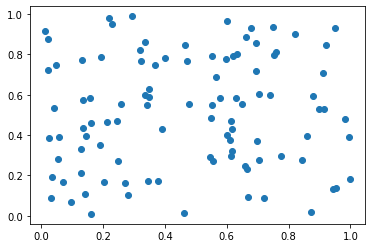

In [4]:
plt.scatter( points.detach().numpy()[:, 0], points.detach().numpy()[:, 1] )

In [122]:
layers = [2, 20, 3]
network = NeuralNet(layers=layers, quadraticForm=True, useAdditionalModel=False, positiveSolution=False)

gamma = {'matrix':0, 'residual':0, 'data':1, 'gradient':1}
lqr = LinearQuadraticRegulator2D(network=network, gamma=gamma, correctShift=False)

In [123]:
lrs = [1e-3, 1e-4]
iterations = [500, 1000]

resu = lqr.train(interiorPointCount=100, dataPointCount=10, lrs=lrs, iterations=iterations, useTestData=False, verbose=True)

xInt:  torch.Size([100, 2])
xData:  torch.Size([10, 2])
0 / 1500 (0 / 500), lr:1.0e-03, loss:1.99e-01 (data: 4.24e-02, grad: 1.56e-01, res: 0.00e+00, mat: 0.00e+00)
100 / 1500 (100 / 500), lr:1.0e-03, loss:9.76e-04 (data: 2.43e-04, grad: 7.32e-04, res: 0.00e+00, mat: 0.00e+00)
200 / 1500 (200 / 500), lr:1.0e-03, loss:1.60e-04 (data: 1.94e-05, grad: 1.41e-04, res: 0.00e+00, mat: 0.00e+00)
300 / 1500 (300 / 500), lr:1.0e-03, loss:1.16e-04 (data: 1.98e-05, grad: 9.60e-05, res: 0.00e+00, mat: 0.00e+00)
400 / 1500 (400 / 500), lr:1.0e-03, loss:9.71e-05 (data: 1.95e-05, grad: 7.76e-05, res: 0.00e+00, mat: 0.00e+00)
500 / 1500 (0 / 1000), lr:1.0e-04, loss:8.22e-05 (data: 1.90e-05, grad: 6.32e-05, res: 0.00e+00, mat: 0.00e+00)
600 / 1500 (100 / 1000), lr:1.0e-04, loss:3.83e-05 (data: 1.15e-05, grad: 2.68e-05, res: 0.00e+00, mat: 0.00e+00)
700 / 1500 (200 / 1000), lr:1.0e-04, loss:1.84e-05 (data: 6.84e-06, grad: 1.16e-05, res: 0.00e+00, mat: 0.00e+00)
800 / 1500 (300 / 1000), lr:1.0e-04, loss:9

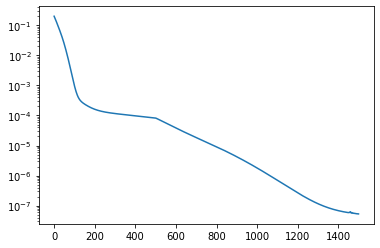

In [124]:
plt.plot( resu['loss'] )
plt.yscale('log')

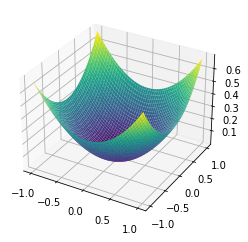

In [125]:
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)

X, Y = np.meshgrid(x, y)
space = lqr.getEvaluationPoints()

Z = lqr.network.computeValueFunction(space).reshape(-1, 100)

ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z.detach().cpu().numpy(), cmap='viridis');